In [1]:
from disk_utils_jax import jax_model, jax_model_scal
from regression import log_likelihood, log_likelihood_1d, manual_regression
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
import numpy as np

jax.config.update("jax_debug_nans", False)

## Defining Disk and SPF Parameters

In [2]:
disk_params1 = {}
disk_params1['inclination'] = 60. #In degrees
disk_params1['position_angle'] = 50. #In Degrees
disk_params1['alpha_in'] = 8. #The inner power law
disk_params1['alpha_out'] = -5. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [3]:
disk_params2 = {}
disk_params2['inclination'] = 30. #In degrees
disk_params2['position_angle'] = 10. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [4]:
# Scattering Phase Function Parameters
spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

## Creating Disk Models

In [5]:
# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
                              spf_params={'g1': 0.9, 'g2': -0.2, 'weight': 0.7})
end = datetime.now()
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params2,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:2683: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)  # type: ignore
2024-05-31 16:29:10.015134: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


0:00:03.592822
0:00:00.000720


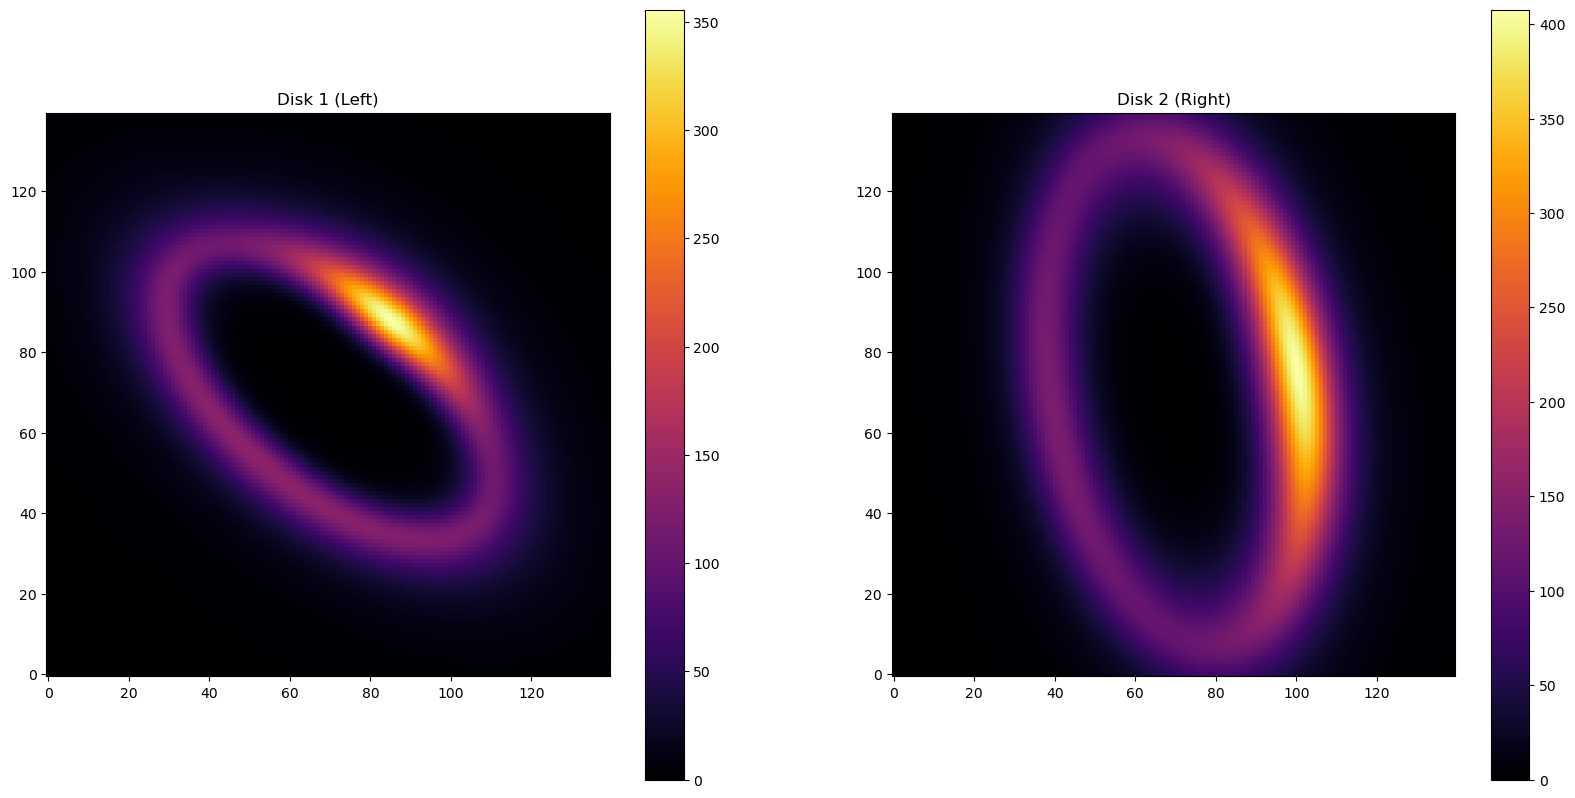

In [6]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image1, origin='lower', cmap='inferno')
axes[0].set_title("Disk 1 (Left)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1].set_title("Disk 2 (Right)")
plt.colorbar(im,ax=axes[1])

## Timing Model Methods

In [7]:
def test():
    jax_model(DustEllipticalDistribution2PowerLaws, HenyeyGreenstein_SPF, disk_params=disk_params1,)

%timeit test

3.82 ns ± 0.0111 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [8]:
#def test():
#    jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
#                              spf_params={'g1': 0.9, 'g2': -0.2, 'weight': 0.7})

#%timeit test

3.81 ns ± 0.00218 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


## Add Noise

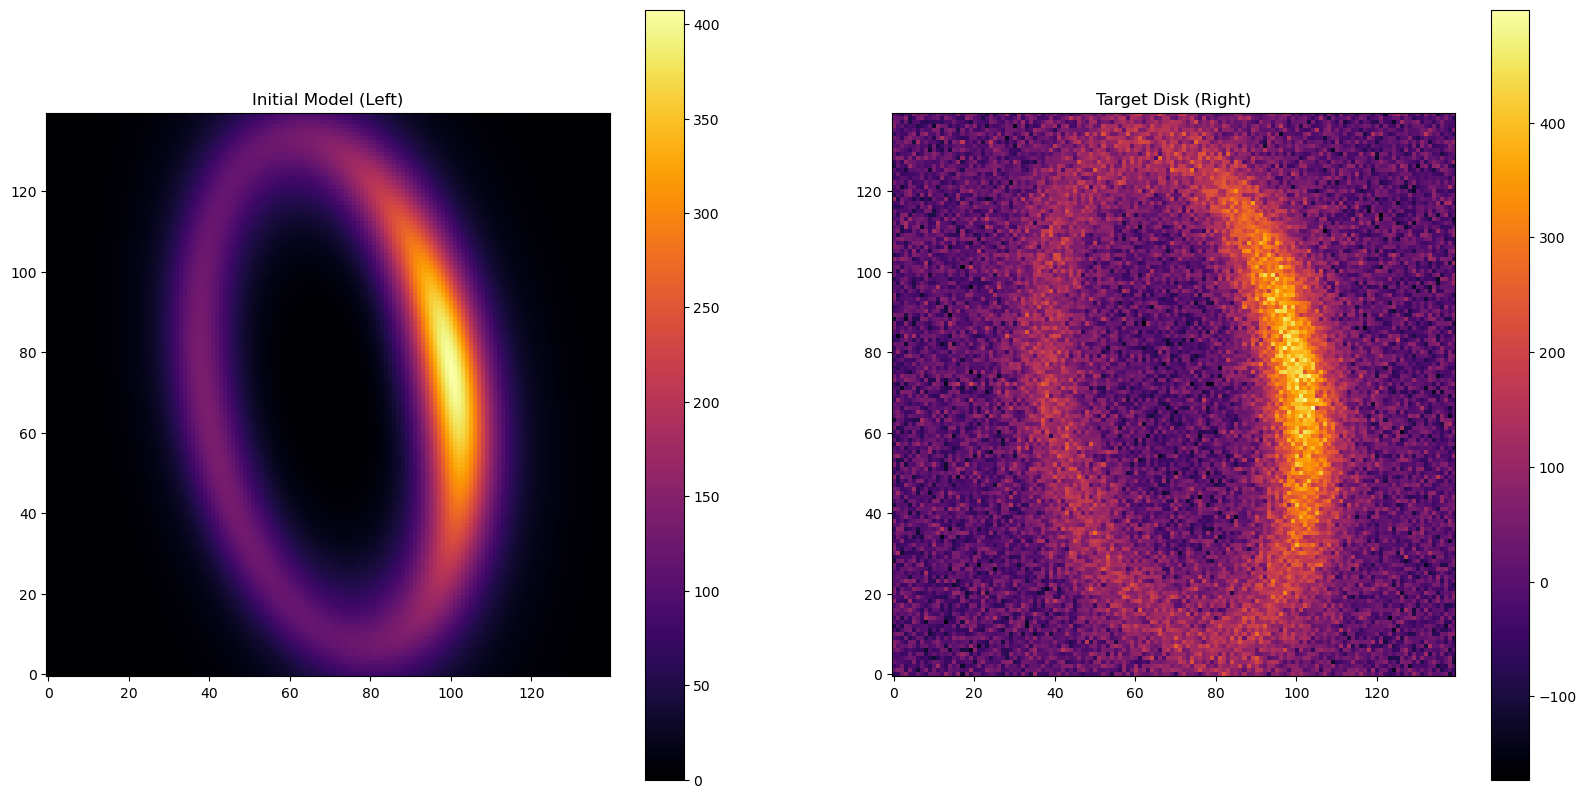

In [9]:
noise_level = 50
noise = np.random.normal(0, noise_level, disk_image1.shape)

fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0].set_title("Initial Model (Left)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk (Right)")
plt.colorbar(im,ax=axes[1])

## Testing Jax Grad with Disk Model Methods

In [10]:
#grad_func = jax.grad(jax_model_scal, argnums=(2, 3))
#print(grad_func(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params))

## Log-Likelihood Testing

In [11]:
ll2 = log_likelihood(DustEllipticalDistribution2PowerLaws,DoubleHenyeyGreenstein_SPF,disk_params2,spf_params,disk_image2+noise,
           np.ones(disk_image2.shape)*noise_level)
ll1 = log_likelihood(DustEllipticalDistribution2PowerLaws,DoubleHenyeyGreenstein_SPF,disk_params1,spf_params,disk_image2+noise,
           np.ones(disk_image2.shape)*noise_level)

print("Likelihood of disk 2 model: {x}".format(x=ll2))
print("Likelihood of disk 1 model: {x}".format(x=ll1))

Likelihood of disk 2 model: -86253.78125
Likelihood of disk 1 model: -122329.375


## Testing Jax Grad with Log-Likelihood Method

In [12]:
ll_grad_func = jax.grad(log_likelihood, argnums=(2,3))
print(ll_grad_func(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params1, spf_params, disk_image2+noise, np.ones(disk_image2.shape)*noise_level))

({'alpha_in': Array(nan, dtype=float32, weak_type=True), 'alpha_out': Array(nan, dtype=float32, weak_type=True), 'flux_scaling': Array(-0.05658, dtype=float32, weak_type=True), 'inclination': Array(0., dtype=float32, weak_type=True), 'position_angle': Array(nan, dtype=float32, weak_type=True), 'sma': Array(nan, dtype=float32, weak_type=True)}, {'g1': Array(nan, dtype=float32, weak_type=True), 'g2': Array(nan, dtype=float32, weak_type=True), 'weight': Array(nan, dtype=float32, weak_type=True)})


## Testing Scipy-Optimize Minimize with Log-Likelihood

In [13]:
import numpy as np

# using disk 1 params as initial parameters
disk_params_1d = np.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

In [14]:
# comparing disk 1 model to the disk 2 noise model
print(log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params1, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level))

# comparing disk 2 model to the disk 2 noise model
print(log_likelihood_1d(disk_params_1d, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params, disk_params1['flux_scaling'],
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level))

-122329.375


/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:2683: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)  # type: ignore


-122329.375


In [15]:
from scipy.optimize import minimize

ll = lambda *args: -log_likelihood_1d(*args)
no_grad_method = "Nelder-Mead"

start = datetime.now()
soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method = no_grad_method)
end = datetime.now()
print(end-start)

print(soln)
print(soln.x)
print(disk_params_1d)

0:00:00.113940
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 86252.515625
             x: [ 5.014e+00 -6.982e+00  3.992e+01  8.813e+01  1.002e+01]
           nit: 196
          nfev: 387
 final_simplex: (array([[ 5.014e+00, -6.982e+00, ...,  8.813e+01,
                         1.002e+01],
                       [ 5.014e+00, -6.982e+00, ...,  8.813e+01,
                         1.002e+01],
                       ...,
                       [ 5.014e+00, -6.982e+00, ...,  8.813e+01,
                         1.002e+01],
                       [ 5.014e+00, -6.982e+00, ...,  8.813e+01,
                         1.002e+01]]), array([ 8.625e+04,  8.625e+04,  8.625e+04,  8.625e+04,
                        8.625e+04,  8.625e+04]))
[ 5.01445958 -6.98216797 39.91681662 88.12987137 10.01733095]
[ 8. -5. 30. 60. 50.]


## Displaying Scipy Fit Model

In [16]:
disk_fit = {}
disk_fit['alpha_in'] = soln.x[0]
disk_fit['alpha_out'] = soln.x[1]
disk_fit['sma'] = soln.x[2]
disk_fit['inclination'] = soln.x[3]
disk_fit['position_angle'] = soln.x[4]
disk_fit['flux_scaling'] = disk_params2['flux_scaling']

In [17]:
start = datetime.now()
disk_image_fit = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

0:00:02.684170


Text(0.5, 1.0, 'Target Disk (Right)')

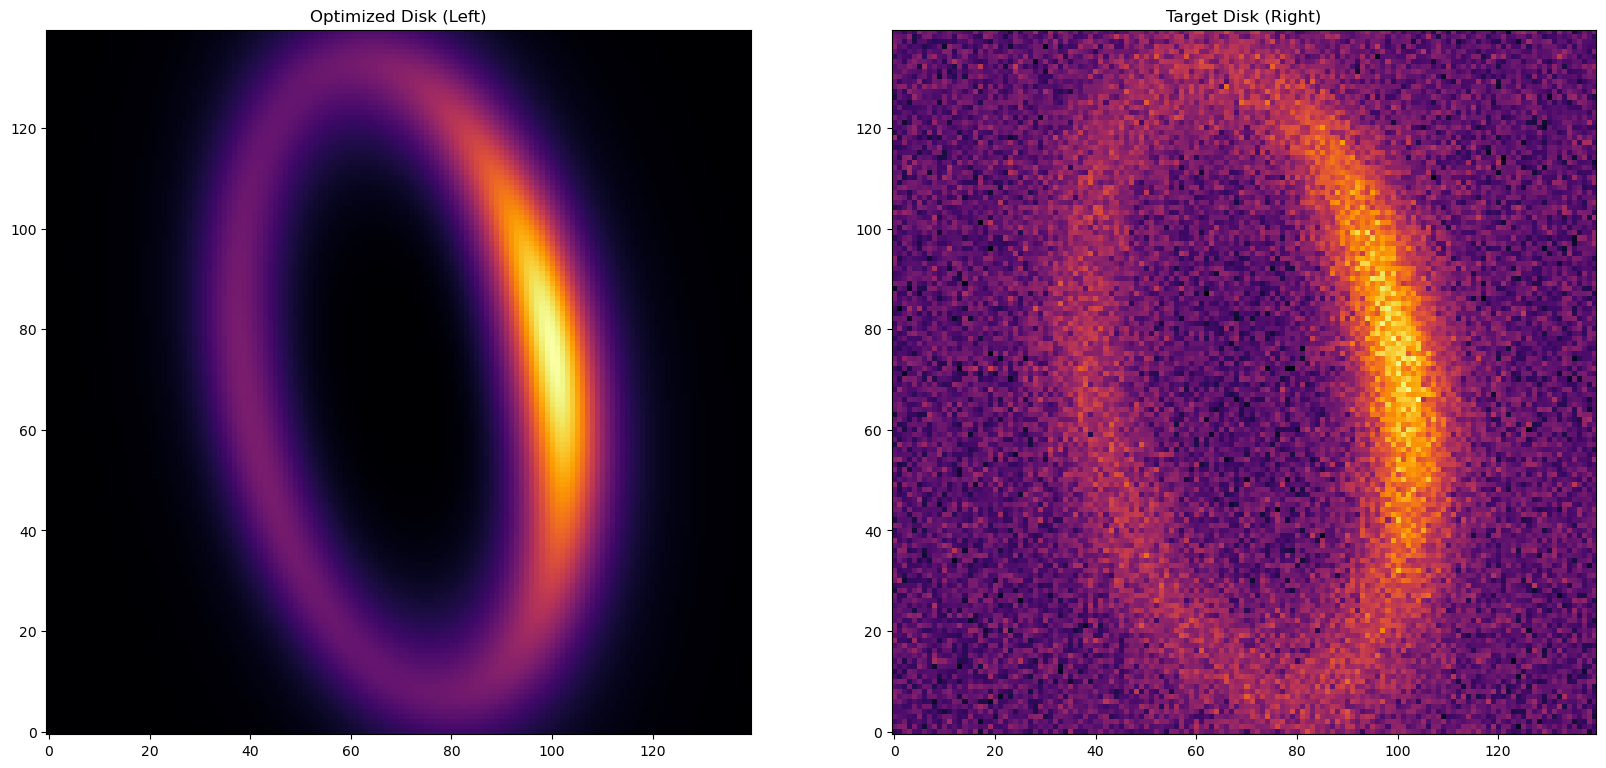

In [18]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

axes[0].imshow(disk_image_fit, origin='lower', cmap='inferno')
axes[0].set_title("Optimized Disk (Left)")

axes[1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk (Right)")

## Grid Search Regression to find Model Fit

In [19]:
#disk_gs_fit = manual_regression(disk_image2, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
#                                jnp.ones(disk_image2.shape)*noise_level)

In [20]:
'''disk_image_gs = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_gs_fit,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})

fig, axes = plt.subplots(1,2, figsize=(20,10))

axes[0].imshow(disk_image_gs, origin='lower', cmap='inferno')
axes[0].set_title("Optimized Disk (Left)")

axes[1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk (Right)")'''

'disk_image_gs = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_gs_fit,\n                               spf_params={\'g1\': 0.5, \'g2\': -0.3, \'weight\': 0.7})\n\nfig, axes = plt.subplots(1,2, figsize=(20,10))\n\naxes[0].imshow(disk_image_gs, origin=\'lower\', cmap=\'inferno\')\naxes[0].set_title("Optimized Disk (Left)")\n\naxes[1].imshow(disk_image2+noise, origin=\'lower\', cmap=\'inferno\')\naxes[1].set_title("Target Disk (Right)")'